# Embedding and Filtering Inference 

Set default input and output directories according to local paths for data

In [ ]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

Import necessary libraries and functions

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
# %matplotlib widget

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

## Embedding

Set checkpoint and other directory paths

In [3]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1' # needs to change...

Fixing some parameters

In [4]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

Load embedding model from checkpoint

In [5]:
emb_ckpt = torch.load(embed_ckpt_dir)
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [6]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

Put model in evaluation state

In [7]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

Define embedding metrics (function gets metrics for one event)

In [8]:
def get_emb_metrics(data_path, emb_model):
    data = torch.load(data_path)
    spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
    
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    e_spatial = utils_torch.build_edges(spatial, emb_model.hparams['r_val'], emb_model.hparams['knn_val'])
    e_spatial_np = e_spatial.cpu().numpy()
    
    # remove R dist from out to in
    R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2)
    
    e_spatial_np = e_spatial_np[:, (R_dist[e_spatial_np[0]] <= R_dist[e_spatial_np[1]])]
    e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
    e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial_np), e_bidir)
    
    cluster_true = 2*len(data.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial_n[0])
    purity = cluster_true_positive/cluster_positive
    eff = cluster_true_positive/cluster_true
    
    return purity, eff

Metrics for one event and all noise configurations

In [9]:
p_all = []
e_all = []
for i in noise_keep:
    data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/1000'
    p, e = get_emb_metrics(data_path, emb_model)
    p_all.append(p)
    e_all.append(e)

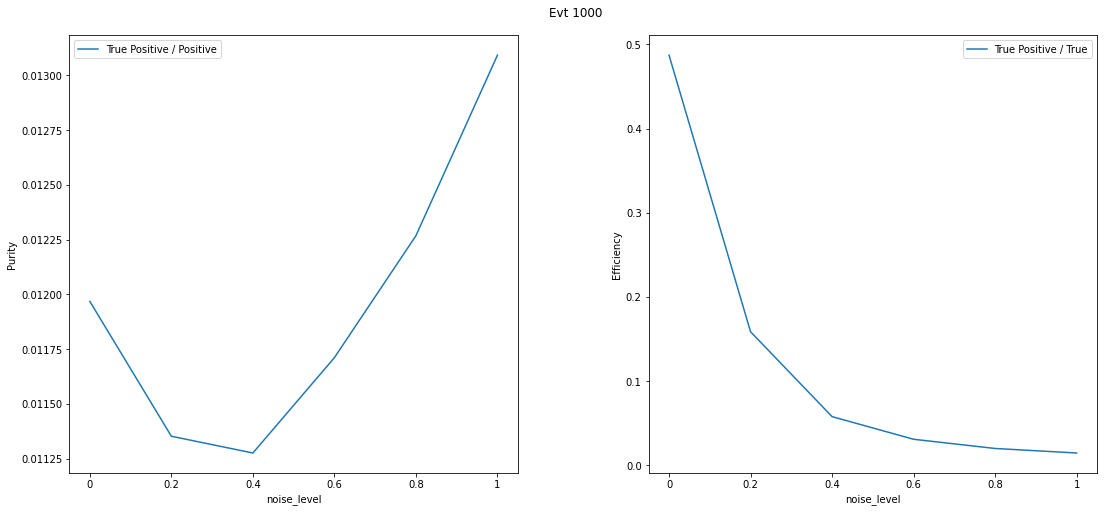

In [10]:
x = np.arange(len(noise_keep))
fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig1.suptitle('Evt 1000')
fig1.tight_layout(w_pad = 10)
ax1.plot(x, p_all, label = 'True Positive / Positive')
ax1.set_xlabel('noise_level')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_keep)
ax1.legend()

ax2.plot(x, e_all, label = 'True Positive / True')
ax2.set_xlabel('noise_level')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_keep)
ax2.legend()

Average metrics for all events and all noise configurations

In [11]:
def get_lvl_emb(mypath,emb_model):
    events = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    p_lvl = []
    e_lvl = []
    for evt in events:
        data_path = join(mypath,evt)
        p, e = get_emb_metrics(data_path, emb_model) 
        p_lvl.append(p)
        e_lvl.append(e)
    
    return np.mean(p_lvl), np.mean(e_lvl)

In [ ]:
p_avg = []
e_avg = []
for i in noise_keep:
    data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/'
    p, e = get_lvl_emb(data_path,emb_model)
    p_avg.append(p)
    e_avg.append(e)

In [ ]:
x = np.arange(len(noise_keep))
fig2, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig2.tight_layout(w_pad = 10)
fig2.suptitle('10 Events')
ax1.plot(x, p_avg, label = 'True Positive / Positive')
ax1.set_xlabel('noise_level')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_keep)
ax1.legend()

ax2.plot(x, e_avg, label = 'True Positive / True')
ax2.set_xlabel('noise_level')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_keep)
ax2.legend()

Tuning Hyperparameters `r_val = 1.7` and `knn_val = 500` with a set level of noise for a specific event.

* `r_val` defines the radius of the clustering method
* `knn_val` defines the number of maximum neighbors in the embedding space

In [ ]:
noise_lvl = 1
evtid = 1000
set_event = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{noise_lvl}/feature_store/{evtid}'

In [ ]:
og_rval = emb_ckpt['hyper_parameters']['r_val']
step = 0.1
stop = 10
p_val = []
e_val = []
for n in range(stop):
    rval = og_rval + step
    print(f"r_val = {rval}")
    cp_emb = emb_ckpt
    cp_emb['hyper_parameters']['r_val'] = rval
    cp_model = LayerlessEmbedding(cp_emb['hyper_parameters'])
    cp_model.load_state_dict(cp_emb['state_dict'])
    cp_model.eval()
    p, e = get_emb_metrics(set_event, cp_model)
    p_val.append(p)
    e_val.append(e)

In [ ]:
x = np.arange(og_rval,rval,step)

fig3, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig3.tight_layout(w_pad = 10)
fig3.suptitle('Eventid {evtid}')
ax1.plot(x, p_val, label = 'True Positive / Positive')
ax1.set_xlabel('r_val')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
ax1.set_xticklabels([','.join(str(r) for r in x)])
ax1.legend()

ax2.plot(x, e_val, label = 'True Positive / True')
ax2.set_xlabel('r_val')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
ax2.set_xticklabels([','.join(str(r) for r in x)])
ax2.legend()